In [2]:
import numpy as np

# Simulate some 3D seismic event data
np.random.seed(42)
seismic_data = np.random.rand(1000, 3)  # 1000 seismic events in 3D


In [7]:
import pandas as pd

In [8]:
# Import Bedretto M0 experiment provisional dataset 
catalog = pd.read_csv('seiscomp-exp-dd_20240415.csv')
catalog_xyz = catalog[['x', 'y', 'z']]
seismic_data = catalog_xyz.to_numpy()

In [9]:
def compute_pcf(seismic_data, r_bins, theta_bins, phi_bins):
    N = len(seismic_data)
    pcf = np.zeros((len(r_bins) - 1, len(theta_bins) - 1, len(phi_bins) - 1))
    
    for i in range(N):
        for j in range(i + 1, N):
            dx, dy, dz = seismic_data[j] - seismic_data[i]
            r = np.sqrt(dx**2 + dy**2 + dz**2)
            theta = np.arccos(dz / r)
            phi = np.arctan2(dy, dx)
            
            r_idx = np.digitize(r, r_bins) - 1
            theta_idx = np.digitize(theta, theta_bins) - 1
            phi_idx = np.digitize(phi, phi_bins) - 1
            
            if 0 <= r_idx < len(r_bins) - 1 and 0 <= theta_idx < len(theta_bins) - 1 and 0 <= phi_idx < len(phi_bins) - 1:
                pcf[r_idx, theta_idx, phi_idx] += 1
    
    # Normalize PCF by the number of points and bin sizes
    normalization = N * (N - 1) / 2
    r_bin_volumes = 4/3 * np.pi * (r_bins[1:]**3 - r_bins[:-1]**3)
    theta_bin_sizes = np.diff(theta_bins)
    phi_bin_sizes = np.diff(phi_bins)
    
    bin_volumes = np.outer(r_bin_volumes, np.outer(theta_bin_sizes, phi_bin_sizes).flatten()).reshape(pcf.shape)
    pcf = pcf / (normalization * bin_volumes)
    
    return pcf


In [49]:
r_bins = np.linspace(0, 10, 10)  # (a,b,n) n distance bins between a and b
theta_bins = np.linspace(0, np.pi, 180)  # 18 bins from 0 to pi
phi_bins = np.linspace(-np.pi, np.pi, 360)  # 36 bins from -pi to pi

pcf = compute_pcf(seismic_data, r_bins, theta_bins, phi_bins)


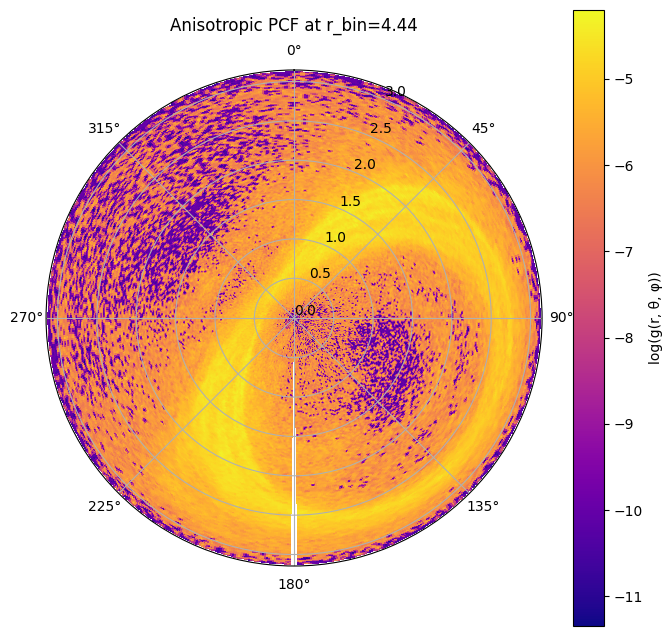

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Assuming the PCF has already been computed and stored in the variable `pcf`

# Select a specific distance bin to plot
r_idx_to_plot = 4  # Arbitrary choice for r_bin
g_to_plot = pcf[r_idx_to_plot, :, :]  # Get the g values for the selected distance bin

# Compute polar coordinates for the plot
theta_bins_centered = theta_bins[:-1] + np.diff(theta_bins)/2
phi_bins_centered = phi_bins[:-1] + np.diff(phi_bins)/2
theta_grid, phi_grid = np.meshgrid(theta_bins_centered, phi_bins_centered, indexing='ij')

# Interpolation for smooth plotting
phi_interp = np.linspace(phi_bins.min(), phi_bins.max(), 720)
theta_interp = np.linspace(theta_bins.min(), theta_bins.max(), 360)
theta_grid_interp, phi_grid_interp = np.meshgrid(theta_interp, phi_interp, indexing='ij')

# Interpolate log_g_to_plot onto a finer grid
log_g_to_plot = np.log10(g_to_plot + 1e-10)  # Convert the PCF to log scale
log_g_interp = griddata((theta_grid.ravel(), phi_grid.ravel()), 
                        log_g_to_plot.ravel(), 
                        (theta_grid_interp, phi_grid_interp), 
                        method='cubic')

# Plotting
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

# Create a polar plot with the RdYlBu color scale
c = ax.pcolormesh(phi_grid_interp, theta_grid_interp, log_g_interp, cmap='plasma', shading='auto')

# Add a color bar with a logarithmic scale
cbar = plt.colorbar(c, ax=ax, orientation='vertical')
cbar.set_label('log(g(r, θ, φ))')

# Adjust the polar plot to set 0 degrees (North) at the top
ax.set_theta_zero_location("N")  # Set 0 degrees to be at the top (North)
ax.set_theta_direction(-1)  # Set the direction of the angle (clockwise)

# Set the title and labels
ax.set_title(f'Anisotropic PCF at r_bin={r_bins[r_idx_to_plot]:.2f}', va='bottom')

plt.show()


TypeError: Dimensions of C (99, 179, 359) should be one smaller than X(360) and Y(100) while using shading='flat' see help(pcolormesh)

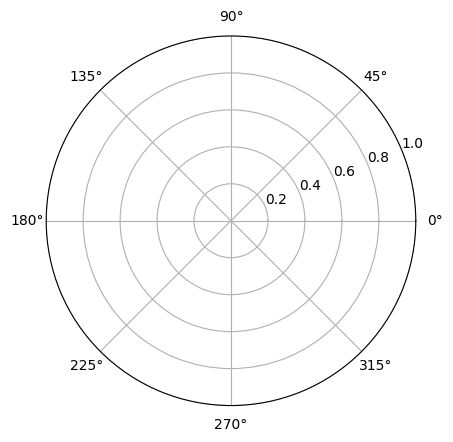

In [42]:
import matplotlib.pyplot as plt
import numpy as np


# Convert theta_bins to range [0, 2*pi] for plotting
theta_bins = np.linspace(0, 2 * np.pi, len(g_r_theta[0]))

# Create the polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Meshgrid for the polar plot
theta, r = np.meshgrid(theta_bins, r_bins)

# Plotting the heatmap on the polar plot
c = ax.pcolormesh(theta, r, pcf, shading='auto', cmap='plasma')

# Add colorbar
fig.colorbar(c, ax=ax, label='Pair Correlation Function $g(r, \\theta)$')

# Set plot labels and title
ax.set_xlabel('Azimuthal Angle (radians)')
ax.set_ylabel('Radial Distance $r$')
ax.set_title('Polar Heatmap of Pair Correlation Function $g(r, \\theta)$')

plt.show()
